<p>
<h1><center> Step by Step CycleGAN - Style Transfer (Photos to Monet Paintings) </center></h1>

This Notebook aims to follow the development of the CycleGAN architecture to capturing special characteristics of one image collection, in our case Monet paintings, and figuring out how these characteristics could be translated into the other image collection, all in the absence of any paired training examples. 

* Compete https://www.kaggle.com/c/gan-getting-started

Sources:

* https://www.kaggle.com/amyjang/monet-cyclegan-tutorial (baseline competition)
* https://www.kaggle.com/dimitreoliveira/introduction-to-cyclegan-monet-paintings
* https://arxiv.org/pdf/1703.10593.pdf (paper)* 
* https://junyanz.github.io/CycleGAN/
* https://hardikbansal.github.io/CycleGANBlog/
* https://www.tensorflow.org/tutorials/generative/cyclegan


# Introduction to CycleGAN

Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks

Adversary Generative Networks (GAN) uses a generator and a discriminator, the generator is not trained to minimize the distance to a specific image but to deceive the discriminator, which allows the model to learn in a generic way.
* The generator has to generate images that are accepted by the discriminator
* The discriminator tries to discover the images that are not real and reject the images generated by the generator.

CycleGAN uses a loss of cycle consistency to allow training without the need for paired data. In unpaired dataset, there is no pre-defined meaningful transformation that generator can learn, so will create it.

The model taking an input image from domain $D_{A}$ which is fed to our first generator  $Generator_{A→B}$  whose job is to transform a given image from domain  $D_{A}$  to an image in target domain $D_{B}$ . This new generated image is then fed to another generator $Generator_{B→A}$ which converts it back into an image, $Cyclic_{A}$, from our original domain $D_{A}$. This output image must be close to original input image to define a meaningful mapping that is absent in unpaired dataset.

So the goal is to learn:

* G:X→Y mapping such that the image distribution of G(X) is indistinguishable from the Y distribution using a contradictory loss
* F:Y→X mapping such that the image distribution of F(Y) is indistinguishable from the X distribution using a contradictory loss.
* The calculation of the total loss of the generators uses:
    * Adversary losses (from Adversary Generative Networks (GAN)) that allow matching the distribution of images generated with the distribution of data in the target domain
    * Loss of cycle consistency to enforce F(G(X)) ≈ X and G(F(Y)) ≈ Y, prevent the learned assignments G and F from contradicting each other
    * Loss of identity, allows the generated image to be similar to the original


Models
&nbsp;
* 2 generators (G_MONET and G_PHOTO) modified U-Net architecture. (will be detailed later https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)
    * The G_MONET generator learns how to transform a photograph into a Monet painting 
    * The G_PHOTO generator learns how to transform a Monet painting into a photograph  
    * As the images are not paired, it is necessary to use two cycles
        * Input Photo -> G_MONET -> Fake Monet -> G_PHOTO -> Cycle Photo
        * Input Monet -> G_PHOTO -> Fake Photo -> G_MONET -> Cycle Monet
&nbsp;
* 2 discriminators (D_MONET AND D_PHOTO) PatchGAN architecture The PatchGAN discriminator tries to classify if each  patch in an image is real or fake. (will be detailed later https://arxiv.org/abs/1611.07004v3)
    * The D_MONET discriminator learns to differentiate if a Monet painting is real or fake, serving to calculate the adversary loss and improve the G_MONET generator
    * The D_PHOTO discriminator learns to differentiate if a photo is real or fake, serving to calculate the adversary loss and improve the G_PHOTO generator
    * As the images are not paired, to calculate the loss of the discriminators, each one of them is executed twice, one with a real image and another with the fake image generated.


## CycleGAN architecture

By way of summary and as a general outline, the following steps will be carried out in each step of the training:

* It starts with two entries:
    * a Photo (Input Photo)
    * a Monet paint (Input Monet)
<br>
* Photo to Monet conversion is performed, running the following generators:
    * G_MONET is executed with Input Photo transforming it into a Fake Monet
    * G_PHOTO is executed with Fake Monet, to try to return to the original photo
    * G_MONET is executed with Input Photo (for the calculation of identity loss)
<br>
* Monet to Photo conversion is performed, running the following generators:
    * G_PHOTO is executed with Input Monet transforming it into a Fake Photo
    * G_MONET is executed with Fake Photo, to try to return to the original frame
    * G_PHOTO is executed with Input Monet (for the calculation of identity loss)
<br>    
* The discriminators are executed:
    * D_PHOTO is executed 2 times to calculate its cross loss:
        * with Input Photo
        * with Fake Photo
    * D_MONET is executed 2 times to calculate its cross loss:
        * with Input Monet
        * with Fake Monet
<br>    
* Calculate the generador loss, en función de
<br>    
* Calculate the gradients using backpropagation.
<br>
* Apply the gradients to the optimizer


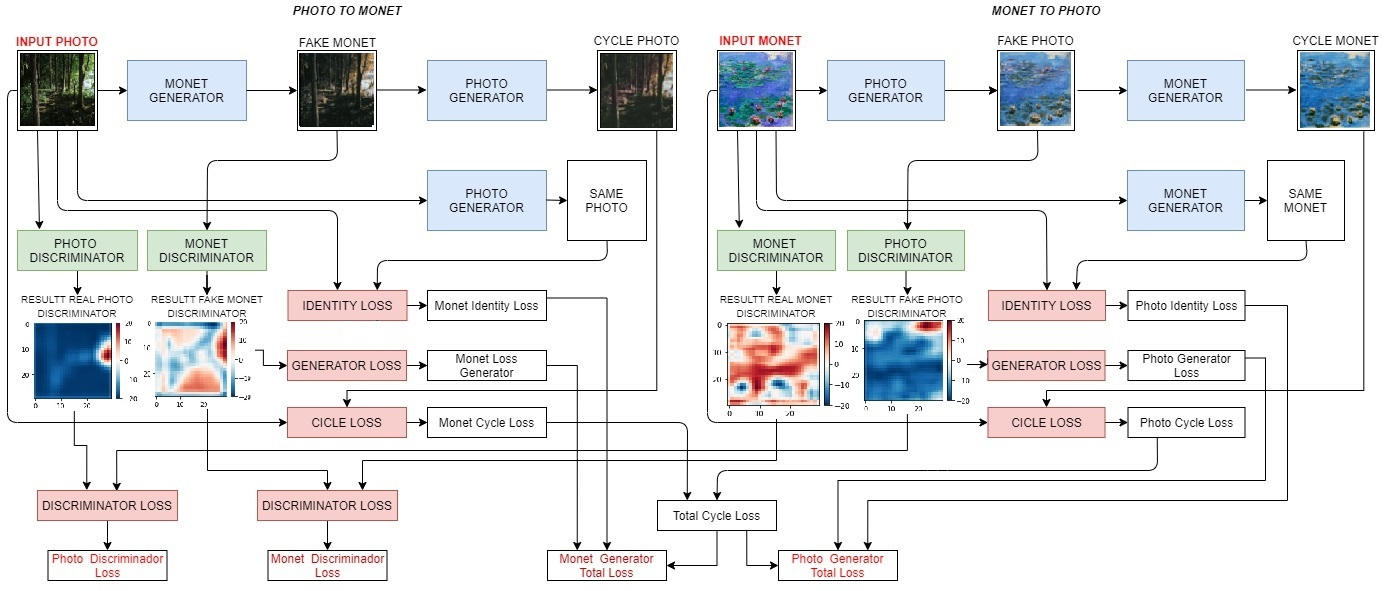

# Implementation

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np


## Set up the input pipeline


Using TPUs

* https://www.kaggle.com/philculliton/a-simple-petals-tf-2-2-notebook
* https://www.kaggle.com/c/tpu-getting-started


It is not necessary to enable the TPUs during the implementation, to carry out the implementation I have left the notebook without any accelerator, and for the first tests of very few epoch and used GPU, only for large trainings I have enabled the TPU.

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
   # strategy = tf.distribute.Strategy.experimental_run_v2(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

### Load the dataset

The data is read from the Tfrec files

In [ ]:
# Google Cloud Storage 
GCS_PATH = KaggleDatasets().get_gcs_path()
print(GCS_PATH)

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet files: ', str(len(MONET_FILENAMES))) 
#print(*MONET_FILENAMES, sep = "\n")

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo files: ', str(len(PHOTO_FILENAMES)))
#print(*PHOTO_FILENAMES, sep = "\n")


Data set size

In [ ]:
# https://www.kaggle.com/dimitreoliveira/introduction-to-cyclegan-monet-paintings
    
import re #Regular expression operations

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

MONET_DATASET_SIZE = count_data_items(MONET_FILENAMES)
PHOTO_DATASET_SIZE = count_data_items(PHOTO_FILENAMES)

print('Monet image files: ', str(MONET_DATASET_SIZE))
print('Photo image files: ', str(PHOTO_DATASET_SIZE))

Functions are defined to read the images as they are, without any type of transformation

In [ ]:
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [ ]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True)

We check that the upload will be done correctly

In [ ]:
plt.figure(figsize=(10,10))

for i, img in enumerate(monet_ds.take(4)):
  plt.subplot(2,4,i+1)
  plt.imshow(img) 

for i, img in enumerate(photo_ds.take(4)):
  plt.subplot(2,4,i+5)
  plt.imshow(img) 
    
plt.show()

The photo file is divided into train, test and validation

In this notebook we will only make a first approach to the architecture, so we will not use the test and validation sets to evaluate the model.

In [ ]:
train_size = int(0.7 * PHOTO_DATASET_SIZE)
test_size = int(0.15 * PHOTO_DATASET_SIZE)
val_size = int(0.15 * PHOTO_DATASET_SIZE)
BUFFER_SIZE = 1000

photo_ds = photo_ds.shuffle(BUFFER_SIZE)

train_photo_3dim_ds = photo_ds.take(train_size)

test_photo_3dim_ds = photo_ds.skip(train_size)
test_photo_3dim_ds = photo_ds.take(test_size)

val_photo_3dim_ds = photo_ds.skip(train_size+test_size)



Monet's paints data will all be used for training

In [ ]:
train_size = int(0.7 * MONET_DATASET_SIZE)
test_size = int(0.15 * MONET_DATASET_SIZE)
val_size = int(0.15 * MONET_DATASET_SIZE)
BUFFER_SIZE = 1000

monet_ds = monet_ds.shuffle(BUFFER_SIZE)

train_monet_3dim_ds = monet_ds

#train_monet_3dim_ds = monet_ds.take(train_size)

#test_monet_3dim_ds = monet_ds.skip(train_size)
#test_monet_3dim_ds = monet_ds.take(test_size)

#val_monet_3dim_ds = monet_ds.skip(train_size+test_size)

### IMAGE PRE-PROCESSING

* resizing image (In this case it would not be necessary to do it, because the images are already in the necessary size. But with this step if we wanted to add new images it would not be necessary to scale them previously)

* normalizing the images to [-1, 1] 

* Random jittering and mirroring to the training dataset. These are some of the image augmentation techniques that avoids overfitting, Random jittering performs:
    * Resize an image to bigger height and width
    * Randomly crop to the target size
    * Randomly flip the image horizontally

Definimos funciones de preprocesamiento.

In [ ]:
IMG_HEIGHT = 256
IMG_WIDTH = 256


def resize(image):
  image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
  return image

# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def denormalize(image):
  image = tf.cast(image, tf.float32)
  image = (image * 0.5 + 0.5) * 255 # Rango 0 a 1 y posteriormente al rango 0..255
  image = tf.cast(image, tf.int32)
  return image

def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

def preprocess_image_train(image):
  image = resize(image)
  image = random_jitter(image)
  image = normalize(image)
  return image

def preprocess_image_test(image):
  image = resize(image)
  image = normalize(image)
  return image

Image preprocessing is added to the pipeline, depending on the set, train or test/validation

The batch dimension is added

In [ ]:
train_photo_ds = train_photo_3dim_ds.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_photo_ds = test_photo_3dim_ds.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

val_photo_ds = val_photo_3dim_ds.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)


train_monet_ds = train_monet_3dim_ds.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

# test_monet_ds = test_monet_3dim_ds.map(
#     preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
#     BUFFER_SIZE).batch(1)

# val_monet_ds = val_monet_3dim_ds.map(
#     preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
#     BUFFER_SIZE).batch(1)

It is checked again that the upload will be successful

In [ ]:
plt.figure(figsize=(10,10))

for i, img in enumerate(train_monet_ds.take(4)):
  plt.subplot(2,4,i+1)
  plt.imshow(denormalize(img[0,...]), vmin=0, vmax=255) # first dimension (batch) is eliminated and we denormalize the image 
    
for i, img in enumerate(train_photo_ds.take(4)):
  plt.subplot(2,4,i+5)
  plt.imshow(denormalize(img[0,...]), vmin=0, vmax=255) # first dimension (batch) is eliminated and we denormalize the image
    
plt.show()

Examples are saved for implementation testing

In [ ]:
example_photo = next(iter(test_photo_ds)) # includes batch dimension and the photo processed according to the pipeline (test set only normalization)
example_monet = next(iter(train_monet_ds)) # includes batch dimension and the photo processed according to the pipeline

plt.subplot(1,2,1)
plt.imshow(desnormalize(example_photo[0,...]), vmin=0, vmax=255) # first dimension (batch) is eliminated and we denormalize the image

plt.subplot(1,2,2)
plt.imshow(desnormalize(example_monet[0,...]), vmin=0, vmax=255) # first dimension (batch) is eliminated and we denormalize the image

plt.show()


Test random jitter

In [ ]:
example_monet_origin = desnormalize(example_monet[0,...])

plt.figure(figsize=(15,15))
for i in range(4):
  image = random_jitter(example_monet_origin)
  plt.subplot(1, 4, i+1)
  plt.imshow(image)
  plt.axis('off')
plt.show()


## MODEL

To build the model we will follow the following steps:
1. Build the Generator
1. Build the Discriminador
1. Define Generator loss
1. Define Discriminator loss
1. Define the optimizers


### Build the Generator

The original paper CycleGAN uses a modified based on resnet generator. In this Notebook, a modified unet generator is used for simplicity, as in 

https://www.tensorflow.org/tutorials/generative/cyclegan

The architecture of the generator is a modified U-Net, consisting of an encoder block and a decoder block, each of them is made up of simpler blocks of layers:

* Each block of the encoder, we call it downsample-k where k denotes the number of filters, this block performs an image compression operation (downsample). It consists of the following layers 
  * Convolution 
  * Instance Normalization (not apply to the first block)
  * Leaky ReLU
* In the decoder we can find two types of blocks, depending on whether a dropout operation is performed or not, we will call each one of them upsampleD-k and upsample-k, since they are performing a decompression. Each of these blocks is made up of:
  * Transposed Convolution
  * Instance Normalization
  * Dropout (applied to the first 3 blocks) 
  * ReLU      
* Skip connections exist between encoder and decoder.
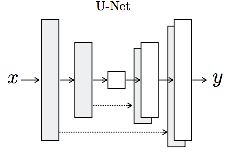



For the implementation of the blocks that make up the coding part of the generator, a "downsample" function will be created that passing the number of filters to it and if normalization is applied, it will create a keras.Sequential object

In [ ]:
def downsample(filters, apply_norm=True):
  result = keras.Sequential()

  initializer = tf.random_normal_initializer(0,0.02)

  # Capa convolucional
  result.add(layers.Conv2D(filters,
                    kernel_size=4,
                    strides=2,
                    padding="same",
                    kernel_initializer=initializer,
                    use_bias=not apply_norm)) # al aplicar BatchNormalization ya tiene implicito el sesgo

  # Capa Normalization
  if apply_norm:
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)) # Cyclegan usa la normalización de instancias

  # Capa de activación
  result.add(layers.LeakyReLU())

  return result

In [ ]:
# A test is performed to verify that it does not give an error
down_model = downsample(3)
down_result = down_model(example_photo, 0)
print (down_result.shape)

For the implementation of the blocks that make up the decoding part of the generator, an "upsample" function will be created that passing the number of filters to it and if dropout is applied, it will create a keras.Sequential object

In [ ]:

def upsample(filters, apply_dropout=True):
  result = keras.Sequential()

  initializer = tf.random_normal_initializer(0,0.02)

  # Capa convolucional inversa
  result.add(layers.Conv2DTranspose(filters,
                            kernel_size=4,
                            strides=2,
                            padding="same",
                            kernel_initializer=initializer,
                            use_bias=False)) # al aplicar BatchNormalization ya tiene implicito el sesgo

  # Capa Normalization
  gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
  result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))  # Cyclegan usa la normalización de instancias
    
  
  # Capa Dropout
  if apply_dropout:
    result.add(layers.Dropout(0.5))

  # Capa de activación
  result.add(layers.ReLU())

  return result

In [ ]:
# A test is performed to verify that it does not give an error
up_model = upsample(3)
up_result = up_model(down_result)
print (up_result.shape)

Next, a diagram of the Generator is presented, in which the inputs and outputs of the different blocks can be seen.

* The red arrows represent the execution of a downsample-k block
* The blue arrows represent the execution of an upsampleD-k block (with Dropout)
* The green arrows represent the execution of an upsample-k block (without Dropout)
* Lastly, an output layer, represented by a pink arrow is executed, which is simply Transposed Convolution of 3 filters to convert the output into a 256X256 image by 3 channels


All convolutional layers of downsample, have the parameter strides = 2, which causes the dimensions to be reduced by half, likewise the Transposed Convolution layers of upsample also have the parameter strides = 2 so the dimensions are doubled. In the first two dimensions, not counting the Batch size dimension.

The size of the 3 dimension will coincide with the number of filters applied.



In [ ]:
def Generator():

  inputs = layers.Input(shape=[256,256,3])

  down_stack = [ 
                downsample(64, apply_norm=False), # [bs, 128, 128, 64] 
                downsample(128), # [bs, 64, 64, 128]
                downsample(256), # [bs, 32, 32, 256]
                downsample(512), # [bs, 16, 16, 512]
                downsample(512), # [bs, 8, 8, 512]
                downsample(512), # [bs, 4, 4, 512]
                downsample(512), # [bs, 2, 2, 512]
                downsample(512), # [bs, 1, 1, 512]
  ]

  up_stack = [
                upsample(512), # [bs, 2, 2, 1024] 
                upsample(512), # [bs, 4, 4, 1024]
                upsample(512), # [bs, 8, 8, 1024]
                upsample(512, apply_dropout=False), # [bs, 16, 16, 1024]
                upsample(256, apply_dropout=False), # [bs, 32, 32, 512]
                upsample(128, apply_dropout=False), # [bs, 64, 64, 256]
                upsample(64, apply_dropout=False), # [bs, 128, 128, 128]
  ]  

  # Output layer
  initializer = tf.random_normal_initializer(0,0.02)
  last = layers.Conv2DTranspose(filters = 3, # Number of image channels
                                kernel_size=4,
                                strides=2,
                                padding="same",
                                kernel_initializer=initializer,
                                activation="tanh" # output -1 to 1
                                )
  
  x = inputs
  skips = []
  
  # We add the Encoder blocks to the model and save the outputs to later perform the Skip Connections
  for down in down_stack:
    x = down(x)  
    skips.append(x)
  

  # We eliminate the last layer of the Skips Connections, 
  # since it will be a direct input in the first block of the Decoder 
  # and we turn the Skips around since the second layer must connect 
  # with the penultimate output of the Encoder, the third with the penultimate . 
  # and so on successively
  skips = reversed(skips[:-1]) 

  # We add the Decoder blocks to the model and sthe Skip Connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = layers.Concatenate()([x,skip])
  x = last(x)

  return keras.Model(inputs=inputs, outputs=x)

In [ ]:
 # probamos que crea el modelo y mostramos arquitectura
generator_g = Generator()
tf.keras.utils.plot_model(generator_g, show_shapes=True, dpi=64)


GENERATOR INITIAL TEST

In [ ]:
# We pass the denormalized photo so that some result can be seen, since the model is not trained
photo = desnormalize(example_photo[0,...])
example_gen_output_y = generator_g(photo[tf.newaxis,...], training=False)

plt.subplot(1,2,1)
plt.imshow(photo, vmin=0, vmax=255) 

plt.subplot(1,2,2)
plt.imshow(example_gen_output_y[0]) 

plt.show()

## Discriminador

Se utiliza en vez de un discriminador que devuelve si la imagen es real o no, una red que devuelve si trozos de la imagen se pueden considerar reales.

Red convolucional Patchga


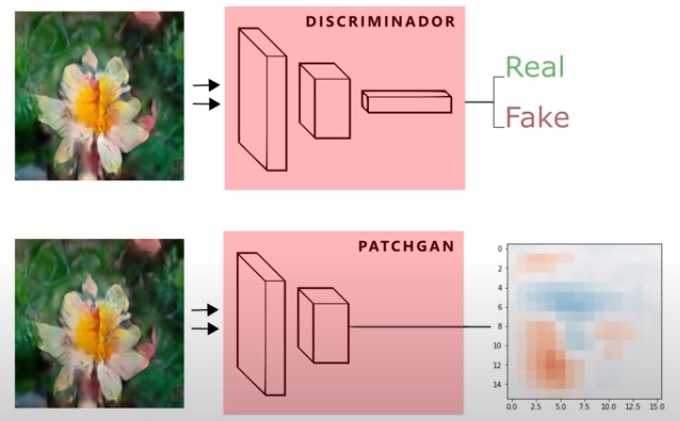


El discriminador es un PatchGAN.
  * Cada bloque en el discriminador es (Conv -> InstanceNormalization -> Leaky ReLU)
  * La forma de la salida después de la última capa es (batch_size, 30, 30, 1)
  * Cada parche de 30x30 de la salida clasifica una parte de 70x70 de la imagen de entrada (dicha arquitectura se llama PatchGAN).
  * El discriminador recibe 2 entradas.
    * Imagen de entrada y la imagen de destino, que debe clasificar como real.
    * Imagen de entrada y la imagen generada (salida del generador), que debe clasificar como falsa.
    * Concatenamos estas 2 entradas juntas en el código ( tf.concat([inp, tar], axis=-1) )

In [ ]:
def Discriminator():
  
  ini = layers.Input(shape=[256, 256, 3], name="input_img") 

  down1 = downsample(64, apply_norm=False)(ini) # [bs, 128, 128, 64] el tamaño se reduce a la mitad strides=2 y la cuarta dimensión coincide con los filtros a aplicar
  down2 = downsample(128)(down1) # [bs, 64, 64, 128]
  down3 = downsample(256)(down2) # [bs, 32, 32, 256]
  
  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)

  initializer = tf.random_normal_initializer(0., 0.02)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  # Capa Normalization
  gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
  norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return keras.Model(inputs=ini, outputs=last)


In [ ]:
discriminator_y = Discriminator()
tf.keras.utils.plot_model(discriminator_y, show_shapes=True, dpi=64)

PRUEBA INICIAL DEL DISCRIMINADOR

In [ ]:
#Pasamos la foto desnormalizada para que se vea algún resultado
photo = desnormalize(example_photo[0,...])
example_gen_output_y = generator_g(photo[tf.newaxis,...], training=False)
example_disc_out = discriminator_y([example_photo, example_gen_output_y], training=False)

print(example_disc_out.shape)


plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
plt.imshow(photo, vmin=0, vmax=255) 

plt.subplot(1,3,2)
plt.imshow(example_gen_output_y[0,...]) 

plt.subplot(1,3,3)
m = example_disc_out[0,...,-1].numpy()*1000
im = plt.imshow(m, vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar(im,fraction=0.046, pad=0.04)

plt.show()

### Modelo CycleGAN generadores y discriminadores

El modelo consta de 2 generadores (G y F) y 2 discriminadores (X e Y).

* El generador G aprende a transformar la imagen X en la imagen Y 
* El generador F aprende a transformar la imagen Y en la imagen X 
* Discriminador D_X aprende a diferenciar entre la imagen X y la imagen generada X ( F(Y) ).
* El discriminador D_Y aprende a diferenciar entre la imagen Y y la imagen generada Y ( G(X) ).

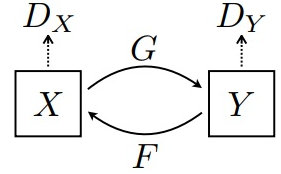



In [ ]:
with strategy.scope():
    
    generator_monet = Generator()
    generator_photo = Generator()

    discriminator_monet = Discriminator()
    discriminator_photo = Discriminator()

### Ejemplo del modelo

A su vez este modelo se ejecuta dos veces:

* Partiendo de la photo se genera una simulación de un cuadro de monet y posteriormente desde esta simulación se intenta generar la foto original

* Partiendo del monet se genera una simulación de una foto y posteriormente desde esta simulación se intenta generar el monet original

Una vez que tenemos las imagenes es necesario discriminar por lo que existira un discriminador para que la foto se parezca a la foto original y otro para que la 

In [ ]:
photo = desnormalize(example_photo[0,...])
monet = desnormalize(example_monet[0,...])

# desde photo generamos Monet (fake) y regeneramos de nuevo la foto (cycle)
example_gen_output_monet_fake = generator_monet(photo[tf.newaxis,...], training=False)
example_gen_output_photo_cycle = generator_photo(example_gen_output_monet_fake, training=False)

# Ejecutamos el discriminador para Monet (fake)
example_disc_out_monet = discriminator_monet(example_gen_output_monet_fake, training=False)


# desde Monet generamos photo (fake) y regeneramos de nuevo Monet (cycle) 
example_gen_output_photo_fake = generator_photo(monet[tf.newaxis,...], training=False)
example_gen_output_monet_cycle = generator_monet(example_gen_output_photo_fake, training=False)

# Ejecutamos el discriminador para Foto (fake)
example_disc_out_photo = discriminator_photo(example_gen_output_photo_fake, training=False)


plt.figure(figsize=(10,10))

# Foto entrada
plt.subplot(2,4,1)
plt.imshow(photo, vmin=0, vmax=255) 

# Monet generado
plt.subplot(2,4,2)
m = example_gen_output_monet_fake[0,...].numpy()
print(np.min(m), np.max(m))
contrast = 100
plt.imshow(example_gen_output_monet_fake[0,...]*contrast) 

# Photo Cycle
plt.subplot(2,4,3)
m = example_gen_output_photo_cycle[0,...].numpy()
print(np.min(m), np.max(m))
contrast = 100
plt.imshow(example_gen_output_photo_cycle[0,...]*contrast) 

# Resultado discriminador Monet 
plt.subplot(2,4,4)
m = example_disc_out_monet[0,...,-1].numpy()
print(np.min(m), np.max(m))
contrast = 1000
im = plt.imshow(m*contrast, vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar(im,fraction=0.046, pad=0.04)



# Monet entrada
plt.subplot(2,4,5)
plt.imshow(monet, vmin=0, vmax=255) 

# Photo generado
plt.subplot(2,4,6)
m = example_gen_output_photo_fake[0,...].numpy()
print(np.min(m), np.max(m))
contrast = 100
plt.imshow(example_gen_output_photo_fake[0,...]*contrast) 

# Monet Cycle
plt.subplot(2,4,7)
m = example_gen_output_monet_cycle[0,...].numpy()
print(np.min(m), np.max(m))
contrast = 100
plt.imshow(example_gen_output_monet_cycle[0,...]*contrast) 

# Resultado discriminador Photo 
plt.subplot(2,4,8)
m = example_disc_out_photo[0,...,-1].numpy()
print(np.min(m), np.max(m))
contrast = 1000
im = plt.imshow(m*contrast, vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar(im,fraction=0.046, pad=0.04)



## Funciones de perdida

En CycleGAN, no hay datos emparejados para entrenar, por lo tanto, no hay garantía de que la entrada x el par objetivo y sean significativos durante el entrenamiento. Por lo tanto, para hacer que la red aprenda el mapeo correcto, los autores proponen la pérdida de consistencia del ciclo.

La consistencia del ciclo significa que el resultado debe estar cerca de la entrada original.

Se utiliza entropía cruzada sigmoidea de las imágenes generadas y las imagenes de entrenamiento, para calcular las perdidas.

In [ ]:
loss_object = keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

### Generator loss

El generador perfecto tendrá la salida del discriminador solo a unos, todo Ok. Por lo tanto, compara la imagen generada con una matriz de 1 para encontrar la pérdida.

In [ ]:
with strategy.scope():
    def generator_loss(generated):
      return loss_object(tf.ones_like(generated), generated)

### Discriminator loss

* La función de pérdida del discriminador toma 2 entradas; imágenes reales, imágenes generadas
* real_loss es una pérdida de entropía cruzada sigmoidea de las imágenes reales y una matriz de unos (ya que estas son las imágenes reales)
* generate_loss es una pérdida de entropía cruzada sigmoidea de las imágenes generadas y una matriz de ceros (ya que estas son las imágenes falsas)
* Entonces la pérdida_total es la suma de la pérdida_real y la pérdida_generada (¿porque se reduce a la mitad? verificar paper)

In [ ]:
with strategy.scope():
    def discriminator_loss(disc_real_output, disc_generated_output):
      #Diferencia entre los true por ser real y el detectado por el discriminador
      real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

      #Diferencia entre los true por ser real y el detectado por el discriminador
      generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)  

      total_disc_loss = (real_loss + generated_loss) / 2

      return total_disc_loss

### Cycle consistency loss

El ciclo consiste en generar una imagen estilo monet desde una foto, esta imagen generada se pasa como entrada al segundo generador, que deberia generar una foto desde una imagen de estilo monet.

El error absoluto media se calcula entre la foto de entrada y la foto de salida del 2º generador.


In [ ]:


with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, param_lambda):
      loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

      return param_lambda * loss1

### Identity loss

El generador de imagenes estilo monet, ... ToDo: completar


In [ ]:
with strategy.scope():
    def identity_loss(real_image, same_image, param_lambda):
      loss = tf.reduce_mean(tf.abs(real_image - same_image))
      return param_lambda * 0.5 * loss

### Inicialización de los optimizadores

In [ ]:
with strategy.scope():
    generator_monet_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    generator_photo_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    discriminator_monet_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    discriminator_photo_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

### Modelo completo

El ciclo de entrenamiento consta de cuatro pasos básicos:

* Obtenga las predicciones.
* Calcula la pérdida.
* Calcule los gradientes usando retropropagación.
* Aplica los degradados al optimizador.

In [ ]:

class CycleGan(keras.Model):
    def __init__(
        self,
        generator_monet,
        generator_photo,
        discriminator_monet,
        discriminator_photo,
        lambda_cycle=10,
        lambda_identity=10
    ):
        super(CycleGan, self).__init__()
        self.generator_monet = generator_monet
        self.generator_photo = generator_photo
        self.discriminator_monet = discriminator_monet
        self.discriminator_photo = discriminator_photo
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity
        
        
    def compile(
        self,
        generator_monet_optimizer,
        generator_photo_optimizer,
        discriminator_monet_optimizer,
        discriminator_photo_optimizer,
        generator_loss,
        discriminator_loss,
        calc_cycle_loss,
        identity_loss
    ):
        super(CycleGan, self).compile()
        self.generator_monet_optimizer = generator_monet_optimizer
        self.generator_photo_optimizer = generator_photo_optimizer
        self.discriminator_monet_optimizer = discriminator_monet_optimizer
        self.discriminator_photo_optimizer = discriminator_photo_optimizer
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss
        self.calc_cycle_loss = calc_cycle_loss
        self.identity_loss = identity_loss
        
        

    def train_step(self, batch_data):

        monet, photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:

            # Obtener predicciones
            # desde photo generamos Monet (fake) y regeneramos de nuevo la foto (cycle)
            gen_output_monet_fake = self.generator_monet(photo, training=False)
            gen_output_photo_cycle = self.generator_photo(gen_output_monet_fake, training=False)

            # desde Monet generamos photo (fake) y regeneramos de nuevo Monet (cycle) 
            gen_output_photo_fake = self.generator_photo(monet, training=False)
            gen_output_monet_cycle = self.generator_monet(gen_output_photo_fake, training=False)

            # generating itself are used for identity loss.
            gen_output_monet_same = self.generator_monet(monet, training=False)
            gen_output_photo_same = self.generator_photo(photo, training=False)


            # Ejecutamos el discriminador para Monet real (entrada) y Monet generado (fake)
            disc_out_monet_real = self.discriminator_monet(monet, training=False)        
            disc_out_monet_fake = self.discriminator_monet(gen_output_monet_fake, training=False)

            # Ejecutamos el discriminador para Foto real (entrada) y Foto (fake)
            disc_out_photo_real = self.discriminator_photo(photo, training=False)
            disc_out_photo_fake = self.discriminator_photo(gen_output_photo_fake, training=False)


            # Calcula la pérdida
            # calculate the loss
            gen_monet_loss = self.generator_loss(disc_out_monet_fake)
            gen_photo_loss = self.generator_loss(disc_out_photo_fake)

            # evaluates total cycle consistency loss
            total_cycle_loss = (self.calc_cycle_loss(monet, gen_output_monet_cycle, self.lambda_cycle) 
                                + self.calc_cycle_loss(photo, gen_output_photo_cycle, self.lambda_cycle))

            # Total generator loss = adversarial loss + cycle loss
            total_gen_monet_loss = (gen_monet_loss + total_cycle_loss 
                                    + self.identity_loss(monet, gen_output_monet_same, self.lambda_identity))
            total_gen_photo_loss = (gen_photo_loss + total_cycle_loss 
                                    + self.identity_loss(photo, gen_output_photo_same, self.lambda_identity))

            disc_monet_loss = self.discriminator_loss(disc_out_monet_real, disc_out_monet_fake)
            disc_photo_loss = self.discriminator_loss(disc_out_photo_real, disc_out_photo_fake)

        # Calculate the gradients for generator and discriminator
        gen_monet_gradients = tape.gradient(total_gen_monet_loss, 
                                            self.generator_monet.trainable_variables)
        gen_photo_gradients = tape.gradient(total_gen_photo_loss, 
                                            self.generator_photo.trainable_variables)

        disc_monet_gradients = tape.gradient(disc_monet_loss, 
                                                self.discriminator_monet.trainable_variables)
        disc_photo_gradients = tape.gradient(disc_photo_loss, 
                                               self.discriminator_photo.trainable_variables)


        # Apply the gradients to the optimizer


        self.generator_monet_optimizer.apply_gradients(zip(gen_monet_gradients,
                                                      self.generator_monet.trainable_variables))
        self.generator_photo_optimizer.apply_gradients(zip(gen_photo_gradients,
                                                     self.generator_photo.trainable_variables)) 

        self.discriminator_monet_optimizer.apply_gradients(zip(disc_monet_gradients,
                                                         self.discriminator_monet.trainable_variables)) 
        self.discriminator_photo_optimizer.apply_gradients(zip(disc_photo_gradients,
                                                        self.discriminator_photo.trainable_variables)) 

        
        return {
            "total_gen_monet_loss": total_gen_monet_loss,
            "total_gen_photo_loss": total_gen_photo_loss,
            "disc_monet_loss": disc_monet_loss,
            "disc_photo_loss": disc_photo_loss
        }
    

In [ ]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        generator_monet, generator_photo, discriminator_monet, discriminator_photo
    )

    cycle_gan_model.compile(
        generator_monet_optimizer = generator_monet_optimizer,
        generator_photo_optimizer = generator_photo_optimizer,
        discriminator_monet_optimizer = discriminator_monet_optimizer,
        discriminator_photo_optimizer = discriminator_photo_optimizer,
        generator_loss = generator_loss,
        discriminator_loss = discriminator_loss,
        calc_cycle_loss = calc_cycle_loss,
        identity_loss = identity_loss
    )


Prueba paso entrenamieno

In [ ]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((train_photo_ds, train_monet_ds)),
    epochs=2
)

### Funciones Auxiliares

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  plt.subplot(1, 2, 1)
  plt.imshow(test_input[0] * 0.5 + 0.5)
  plt.title('Input Image')
  plt.axis('off')
    
  plt.subplot(1, 2, 2)
  plt.imshow(prediction[0] * 0.5 + 0.5)
  plt.title('Predicted Image')
  plt.axis('off')

  plt.show()

In [ ]:
generate_images(generator_monet, example_photo)

Ejemplo de ejecución 

In [ ]:
# desde photo generamos Monet (fake) y regeneramos de nuevo la foto (cycle)
example_gen_output_monet_fake = generator_monet(example_photo, training=False)
example_gen_output_photo_cycle = generator_photo(example_gen_output_monet_fake, training=False)
example_gen_output_photo_same = generator_photo(example_photo, training=False)


# Ejecutamos el discriminador para Photo (real)
example_disc_out_photo_real = discriminator_photo(example_photo, training=False)

# Ejecutamos el discriminador para Monet (fake)
example_disc_out_monet_fake = discriminator_monet(example_gen_output_monet_fake, training=False)


# desde Monet generamos photo (fake) y regeneramos de nuevo Monet (cycle) 
example_gen_output_photo_fake = generator_photo(example_monet, training=False)
example_gen_output_monet_cycle = generator_monet(example_gen_output_photo_fake, training=False)
example_gen_output_monet_same = generator_monet(example_monet, training=False)

# Ejecutamos el discriminador para Monet (real)
example_disc_out_monet_real = discriminator_monet(example_monet, training=False)

# Ejecutamos el discriminador para Foto (fake)
example_disc_out_photo_fake = discriminator_photo(example_gen_output_photo_fake, training=False)

In [ ]:
plt.figure(figsize=(10,10))

# Foto entrada
plt.subplot(4,4,1)
plt.imshow(example_photo[0] * 0.5 + 0.5) 

# Monet generado
plt.subplot(4,4,2)
plt.imshow(example_gen_output_monet_fake[0] * 0.5 + 0.5) 

# Photo Cycle
plt.subplot(4,4,3)
plt.imshow(example_gen_output_photo_cycle[0] * 0.5 + 0.5) 

# Photo Same
plt.subplot(4,4,4)
plt.imshow(example_gen_output_photo_same[0] * 0.5 + 0.5) 

# Discriminador para Photo (real)
plt.subplot(4,4,5)
m = example_disc_out_photo_real[0,...,-1].numpy()
plt.imshow(m, vmin=np.min(m), vmax=np.max(m), cmap='RdBu_r')
plt.colorbar(im,fraction=0.046, pad=0.04)

# Discriminador para Monet (fake)
plt.subplot(4,4,7)
m = example_disc_out_monet_fake[0,...,-1].numpy()
plt.imshow(m, vmin=np.min(m), vmax=np.max(m), cmap='RdBu_r')
plt.colorbar(im,fraction=0.046, pad=0.04)

# Monet entrada
plt.subplot(4,4,9)
plt.imshow(example_monet[0] * 0.5 + 0.5) 

# Foto generado
plt.subplot(4,4,10)
plt.imshow(example_gen_output_photo_fake[0] * 0.5 + 0.5) 

# Monet Cycle
plt.subplot(4,4,11)
plt.imshow(example_gen_output_monet_cycle[0] * 0.5 + 0.5) 

# Monet Same
plt.subplot(4,4,12)
plt.imshow(example_gen_output_monet_same[0] * 0.5 + 0.5) 

# Discriminador para Monet (real)
plt.subplot(4,4,13)
m = example_disc_out_monet_real[0,...,-1].numpy()
plt.imshow(m, vmin=np.min(m), vmax=np.max(m), cmap='RdBu_r')
plt.colorbar(im,fraction=0.046, pad=0.04)

# Discriminador para Photo (fake)
plt.subplot(4,4,15)
m = example_disc_out_photo_fake[0,...,-1].numpy()
plt.imshow(m, vmin=np.min(m), vmax=np.max(m), cmap='RdBu_r')
plt.colorbar(im,fraction=0.046, pad=0.04)


plt.show()

In [ ]:



# Resultado discriminador Monet 
plt.subplot(2,4,4)
m = example_disc_out_monet[0,...,-1].numpy()
print(np.min(m), np.max(m))
contrast = 1000
im = plt.imshow(m*contrast, vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar(im,fraction=0.046, pad=0.04)



# Monet entrada
plt.subplot(2,4,5)
plt.imshow(monet, vmin=0, vmax=255) 

# Photo generado
plt.subplot(2,4,6)
m = example_gen_output_photo_fake[0,...].numpy()
print(np.min(m), np.max(m))
contrast = 100
plt.imshow(example_gen_output_photo_fake[0,...]*contrast) 

# Monet Cycle
plt.subplot(2,4,7)
m = example_gen_output_monet_cycle[0,...].numpy()
print(np.min(m), np.max(m))
contrast = 100
plt.imshow(example_gen_output_monet_cycle[0,...]*contrast) 

# Resultado discriminador Photo 
plt.subplot(2,4,8)
m = example_disc_out_photo[0,...,-1].numpy()
print(np.min(m), np.max(m))
contrast = 1000
im = plt.imshow(m*contrast, vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar(im,fraction=0.046, pad=0.04)


In [ ]:
for img in test_photo_ds.take(5):
    generate_images(generator_monet, img)

In [ ]:
generator_monet.save('generator_monet_20201125')

# Entrenamiento

In [ ]:
# import time
# from IPython.display import clear_output

# EPOCHS = 10
# with strategy.scope():
    
#     for epoch in range(EPOCHS):
#       start = time.time()

#       n = 0
#       for image_photo, image_monet in tf.data.Dataset.zip((train_photo_ds, train_monet_ds)):
#         train_step(image_photo, image_monet)
#         if n % 5 == 0:
#             print(n)  
#             generate_images(generator_monet, example_photo)
#             clear_output(wait=True)
#         n+=1

#       # Using a consistent image (sample_horse) so that the progress of the model
#       # is clearly visible.
#       generate_images(generator_monet, example_photo)
#       print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
#                                                           time.time()-start))


### ANT

SAVE MODEL WEIGHTS

In [ ]:
# import os
# os.mkdir('../output/kaggle/working/output1')

In [ ]:
# from subprocess import check_output
# print(check_output(["ls", ".."]).decode("utf8"))

In [ ]:


# cycle_gan_model.save_weights('../working/cycle_gan_model_00_weights.h5')


In [ ]:
# cycle_gan_model.load_weights('../working/cycle_gan_model_00_weights.h5')

# Visualize our Monet-esque photos

In [ ]:
# _, ax = plt.subplots(5, 2, figsize=(12, 12))
# for i, img in enumerate(photo_ds.take(5)):
#     prediction = monet_generator(img, training=False)[0].numpy()
#     prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
#     img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

#     ax[i, 0].imshow(img)
#     ax[i, 1].imshow(prediction)
#     ax[i, 0].set_title("Input Photo")
#     ax[i, 1].set_title("Monet-esque")
#     ax[i, 0].axis("off")
#     ax[i, 1].axis("off")
# plt.show()

# Create submission file

In [ ]:
# import PIL
# ! mkdir ../images

In [ ]:
# len(photo_ds)

In [ ]:
# i = 1
# for img in photo_ds:
#     prediction = monet_generator(img, training=False)[0].numpy()
#     prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
#     im = PIL.Image.fromarray(prediction)
#     im.save("../images/" + str(i) + ".jpg")
#     i += 1

In [ ]:
# import shutil
# shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")